In [221]:
# Code retrived from https://www.kaggle.com/tarunkr/covid-19-case-study-analysis-viz-comparisons
# Modified by Yichun Zhou
# Installs
# !pip install pycountry_convert 
# !pip install folium
# !pip install calmap
# !pip install pandas==0.25.1
# !pip install wget
import wget
!wget https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_deaths_v3.h5
!wget https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_confirmed_v3.h5
!wget https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_usa_c_v2.h5

/bin/sh: wget: command not found
/bin/sh: wget: command not found
/bin/sh: wget: command not found


In [222]:
# pip install Keras

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
import tensorflow as tf
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests
import calmap

from keras.layers import Input, Dense, Activation, LeakyReLU
from keras import models
from keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [249]:
# Retriving Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Depricated
# df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [250]:
df_covid19

Country_Region          Last_Update        Lat       Long_  \
0             Australia  2020-05-07 16:32:31 -25.000000  133.000000   
1               Austria  2020-05-07 16:32:31  47.516200   14.550100   
2                Canada  2020-05-07 16:32:31  60.001000  -95.001000   
3                 China  2020-05-07 16:32:31  30.592800  114.305500   
4               Denmark  2020-05-07 16:32:31  56.000000   10.000000   
..                  ...                  ...        ...         ...   
182  West Bank and Gaza  2020-05-07 16:32:31  31.952200   35.233200   
183      Western Sahara  2020-05-07 16:32:31  24.215500  -12.885800   
184               Yemen  2020-05-07 16:32:31  15.552727   48.516388   
185              Zambia  2020-05-07 16:32:31 -13.133897   27.849332   
186            Zimbabwe  2020-05-07 16:32:31 -19.015438   29.154857   

     Confirmed  Deaths  Recovered  Active  Incident_Rate  People_Tested  \
0         6897      97       6035     765      27.089871            NaN   
1        15752     609      13698    1445     174.897850            NaN   
2        64746    4369      28578   31799     171.033679            NaN   
3        83974    4637      78944     393       5.978174            NaN   
4        10281     514       7907    1860     177.497232            NaN   
..         ...     ...        ...     ...            ...            ...   
182        374       2        174     198       7.331298            NaN   
183          6       0          5       1       1.004470            NaN   
184         25       5          1      19       0.083820            NaN   
185        146       4        101      41       0.794171            NaN   
186         34       4          5      25       0.228757            NaN   

     People_Hospitalized  Mortality_Rate  UID ISO3  
0                    NaN        1.406409   36  AUS  
1                    NaN        3.866176   40  AUT  
2                    NaN        6.747907  124  CAN  
3                    NaN        5.521947  156  CHN  
4                    NaN        4.999514  208  DNK  
..                   ...             ...  ...  ...  
182                  NaN        0.534759  275  PSE  
183                  NaN        0.000000  732  ESH  
184                  NaN       20.000000  887  YEM  
185                  NaN        2.739726  894  ZMB  
186                  NaN       11.764706  716  ZWE  

[187 rows x 14 columns]

In [251]:
df_confirmed.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  4/27/20  4/28/20  4/29/20  4/30/20  5/1/20  \
0        0        0        0  ...     1703     1828     1939     2171    2335   
1        0        0        0  ...      736      750      766      773     782   
2        0        0        0  ...     3517     3649     3848     4006    4154   
3        0        0        0  ...      743      743      743      745     745   
4        0        0        0  ...       27       27       27       27      30   

   5/2/20  5/3/20  5/4/20  5/5/20  5/6/20  
0    2469    2704    2894    3224    3392  
1     789     795     803     820     832  
2    4295    4474    4648    4838    4997  
3     747     748     750     751     751  
4      35      35      35      36      36  

[5 rows x 110 columns]

In [252]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]
# df_recovered = df_recovered.rename(columns={"Province/State":"state","Country/Region": "country"})

df_covid19.to_csv('df_covid19.csv')
df_covid19

country          Last_Update        Lat       Long_  \
0             Australia  2020-05-07 16:32:31 -25.000000  133.000000   
1               Austria  2020-05-07 16:32:31  47.516200   14.550100   
2                Canada  2020-05-07 16:32:31  60.001000  -95.001000   
3                 China  2020-05-07 16:32:31  30.592800  114.305500   
4               Denmark  2020-05-07 16:32:31  56.000000   10.000000   
..                  ...                  ...        ...         ...   
182  West Bank and Gaza  2020-05-07 16:32:31  31.952200   35.233200   
183      Western Sahara  2020-05-07 16:32:31  24.215500  -12.885800   
184               Yemen  2020-05-07 16:32:31  15.552727   48.516388   
185              Zambia  2020-05-07 16:32:31 -13.133897   27.849332   
186            Zimbabwe  2020-05-07 16:32:31 -19.015438   29.154857   

     Confirmed  Deaths  Recovered  Active  Incident_Rate  People_Tested  \
0         6897      97       6035     765      27.089871            NaN   
1        15752     609      13698    1445     174.897850            NaN   
2        64746    4369      28578   31799     171.033679            NaN   
3        83974    4637      78944     393       5.978174            NaN   
4        10281     514       7907    1860     177.497232            NaN   
..         ...     ...        ...     ...            ...            ...   
182        374       2        174     198       7.331298            NaN   
183          6       0          5       1       1.004470            NaN   
184         25       5          1      19       0.083820            NaN   
185        146       4        101      41       0.794171            NaN   
186         34       4          5      25       0.228757            NaN   

     People_Hospitalized  Mortality_Rate  UID ISO3  
0                    NaN        1.406409   36  AUS  
1                    NaN        3.866176   40  AUT  
2                    NaN        6.747907  124  CAN  
3                    NaN        5.521947  156  CHN  
4                    NaN        4.999514  208  DNK  
..                   ...             ...  ...  ...  
182                  NaN        0.534759  275  PSE  
183                  NaN        0.000000  732  ESH  
184                  NaN       20.000000  887  YEM  
185                  NaN        2.739726  894  ZMB  
186                  NaN       11.764706  716  ZWE  

[187 rows x 14 columns]

In [253]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"
# df_recovered.loc[df_recovered['country'] == "US", "country"] = "USA"


df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"
# df_recovered.loc[df_recovered['country'] == 'Korea, South', "country"] = 'South Korea'

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"
# df_recovered.loc[df_recovered['country'] == 'Taiwan*', "country"] = 'Taiwan'

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"
# df_recovered.loc[df_recovered['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"

df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_covid19.loc[df_covid19['country'] == "Reunion", "country"] = "Réunion"
df_table.loc[df_table['Country_Region'] == "Reunion", "Country_Region"] = "Réunion"
# df_recovered.loc[df_recovered['country'] == "Reunion", "country"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"
# df_recovered.loc[df_recovered['country'] == 'Bahamas, The', "country"] = 'Bahamas'

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"
# df_recovered.loc[df_recovered['country'] == 'Gambia, The', "country"] = 'Gambia'

# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])
# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

#Collecting Continent Information
df_confirmed.insert(2,"continent", [continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in df_table["Country_Region"].values])
# df_recovered.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]] ) 

In [254]:
df_table = df_table[df_table["continent"] != "Others"]
df_deaths[df_deaths["continent" ]== 'Others']
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)

In [255]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    # Tick-Parameters
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')
    
    # Grid
    plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
    plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

    # Plot Title
    plt.title( plt_title,{'fontsize':title_fsize})
    
    # Yaxis sacle
    plt.yscale(scale)
    plt.minorticks_on()
    # Plot Axes Labels
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        # Sub plot
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        # Sub plot
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    ax.set_axisbelow(True)
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')
    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)
        plt.fill_between(date,cases,color=color[i],alpha=0.3)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
    # Plot Axes Labels
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
    # Plot Parameters
    plot_params(ax,axis_label,scale = scale)
    
    # Plot Title
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19 Cases for "+params[1] ,{'fontsize':25})
        
    # Legend Location
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()
        
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = ""#+"output/"

In [256]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]
df_countries_cases = df_countries_cases.drop(['country'],axis=1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

df_countries_cases.fillna(0,inplace=True)
df_continents_cases.fillna(0,inplace=True)

In [257]:
df_t = pd.DataFrame(pd.to_numeric(df_countries_cases.sum()),dtype=np.float64).transpose()
df_t["Mortality Rate (per 100)"] = np.round(100*df_t["Deaths"]/df_t["Confirmed"],2)
df_t.style.background_gradient(cmap='Wistia',axis=1).format("{:.0f}",subset=["Confirmed"])

In [258]:
df_continents_cases["Mortality Rate (per 100)"] = np.round(100*df_continents_cases["Deaths"]/df_continents_cases["Confirmed"],2)
df_continents_cases.style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Pastel1_r',subset=["Incident_Rate"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

In [259]:
# df_countries_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Wistia')
df_countries_cases["Mortality Rate (per 100)"] = np.round(100*df_countries_cases["Deaths"]/df_countries_cases["Confirmed"],2)
df_countries_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Pastel1_r',subset=["Incident_Rate"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

In [275]:
# df_countries_cases = df_countries_cases.reset_index()
c = [88,17,140,10,39]
# df_countries_cases.loc[df_countries_cases['country'] == "Brazil"]
# df_countries_cases.loc[df_countries_cases['country'] == "India"]
a = df_countries_cases.iloc[c]
a = a.drop(columns=['People_Tested', 'People_Hospitalized',"UID"])
a.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Pastel1_r',subset=["Incident_Rate"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality_Rate"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

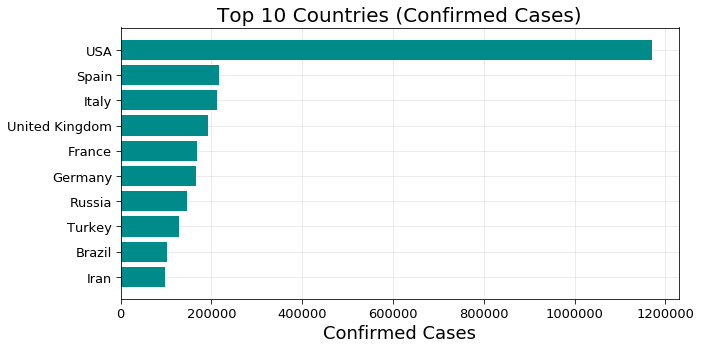

In [17]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Confirmed')["Confirmed"].index[-10:],df_countries_cases.sort_values('Confirmed')["Confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig(out+'Top 10 Countries (Confirmed Cases).png')

#

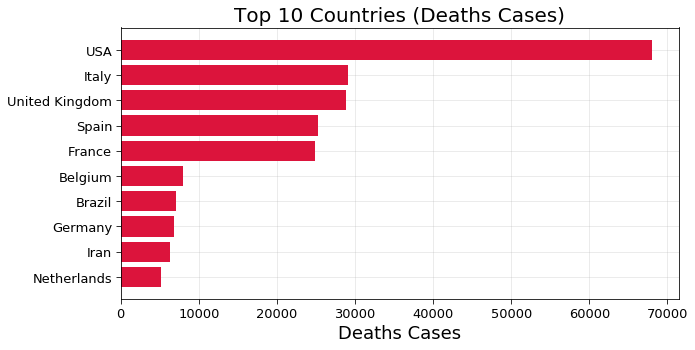

In [21]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Deaths')["Deaths"].index[-10:],df_countries_cases.sort_values('Deaths')["Deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths Cases",fontsize=18)
plt.title("Top 10 Countries (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Deaths Cases).png')

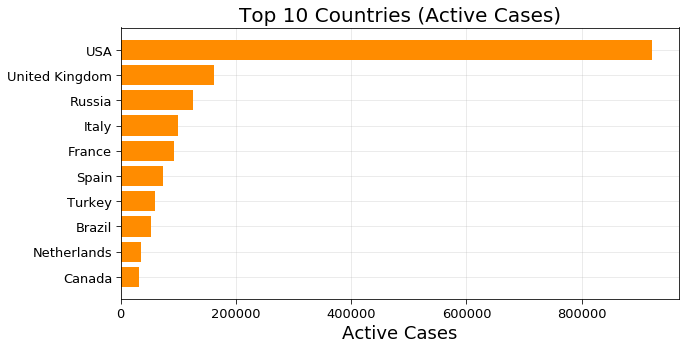

In [22]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Active')["Active"].index[-10:],df_countries_cases.sort_values('Active')["Active"].values[-10:],color="darkorange")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Active Cases",fontsize=18)
plt.title("Top 10 Countries (Active Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Active Cases).png')

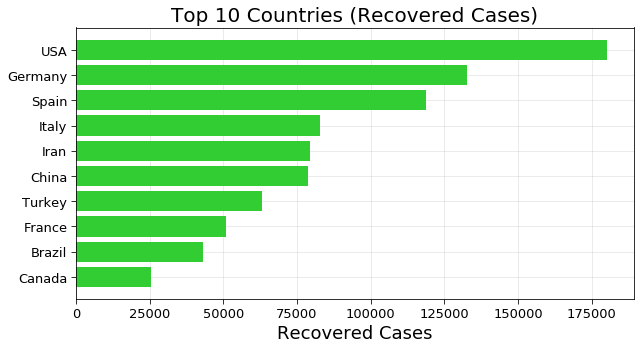

In [23]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Recovered')["Recovered"].index[-10:],df_countries_cases.sort_values('Recovered')["Recovered"].values[-10:],color="limegreen")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Recovered Cases",fontsize=18)
plt.title("Top 10 Countries (Recovered Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Recovered Cases).png')


In [24]:
c = [0,1,2,3,4,7]
df_countries_cases.iloc[:,c].corr().style.background_gradient(cmap='Reds')

In [25]:
df_continents_cases.iloc[:,c].corr().style.background_gradient(cmap='Reds')

In [26]:
df_data = df_table.groupby(['Last_Update', 'Country_Region'])['Confirmed', 'Deaths'].max().reset_index().fillna(0)
df_data["Last_Update"] = pd.to_datetime( df_data["Last_Update"]).dt.strftime('%m/%d/%Y')

fig = px.scatter_geo(df_data, locations="Country_Region", locationmode='country names', 
                     color=np.power(df_data["Confirmed"],0.3)-2 , size= np.power(df_data["Confirmed"]+1,0.3)-1, hover_name="Country_Region",
                     hover_data=["Confirmed"],
                     range_color= [0, max(np.power(df_data["Confirmed"],0.3))], 
                     projection="natural earth", animation_frame="Last_Update", 
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='COVID-19: Progression of spread'
                    )
fig.update_coloraxes(colorscale="hot")
fig.update(layout_coloraxis_showscale=False)
fig.show()

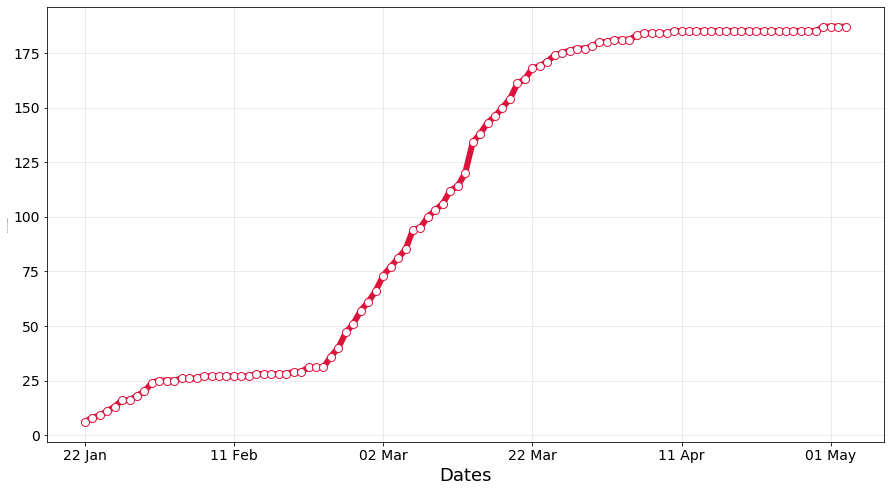

In [27]:
#Number of countries affected over the time
case_nums_country = df_confirmed.groupby("country").sum().drop(['Lat','Long'],axis =1).apply(lambda x: x[x > 0].count(), axis =0)
d = [datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in case_nums_country.index]

f = plt.figure(figsize=(15,8))
f.add_subplot(111)
marker_style = dict(c="crimson",linewidth=6, linestyle='-', marker='o',markersize=8, markerfacecolor='#ffffff')
plt.plot(d, case_nums_country,**marker_style)
plt.tick_params(labelsize = 14)
plt.xticks(list(np.arange(0,len(d),int(len(d)/5))),d[:-1:int(len(d)/5)]+[d[-1]])

#labels
plt.xlabel("Dates",fontsize=18)
plt.ylabel("Number of Countries/Regions",fontsize=1)
plt.grid(alpha = 0.3)

plt.savefig(out+'spread.png')
plt.show()
plt.close()

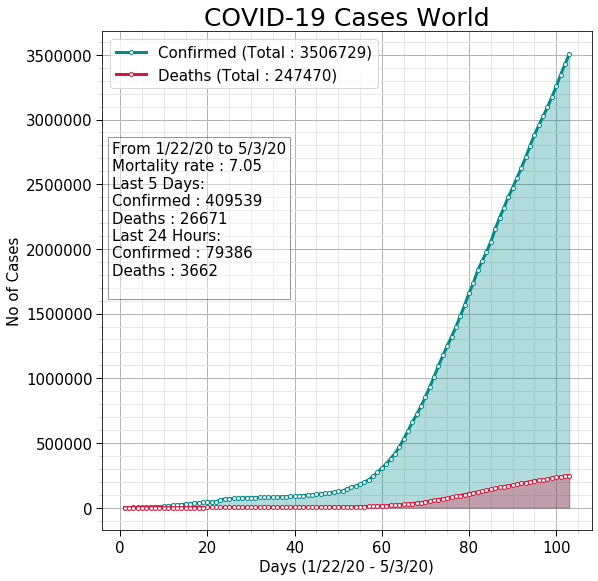

In [28]:
cols = 1
rows = 1
f = plt.figure(figsize=(10,10*rows))

visualize_covid_cases(df_confirmed, df_deaths,continent = "All",figure = [f,rows,cols, 1])

# plt.savefig(out+'COIVD-19-World.png')
plt.show()

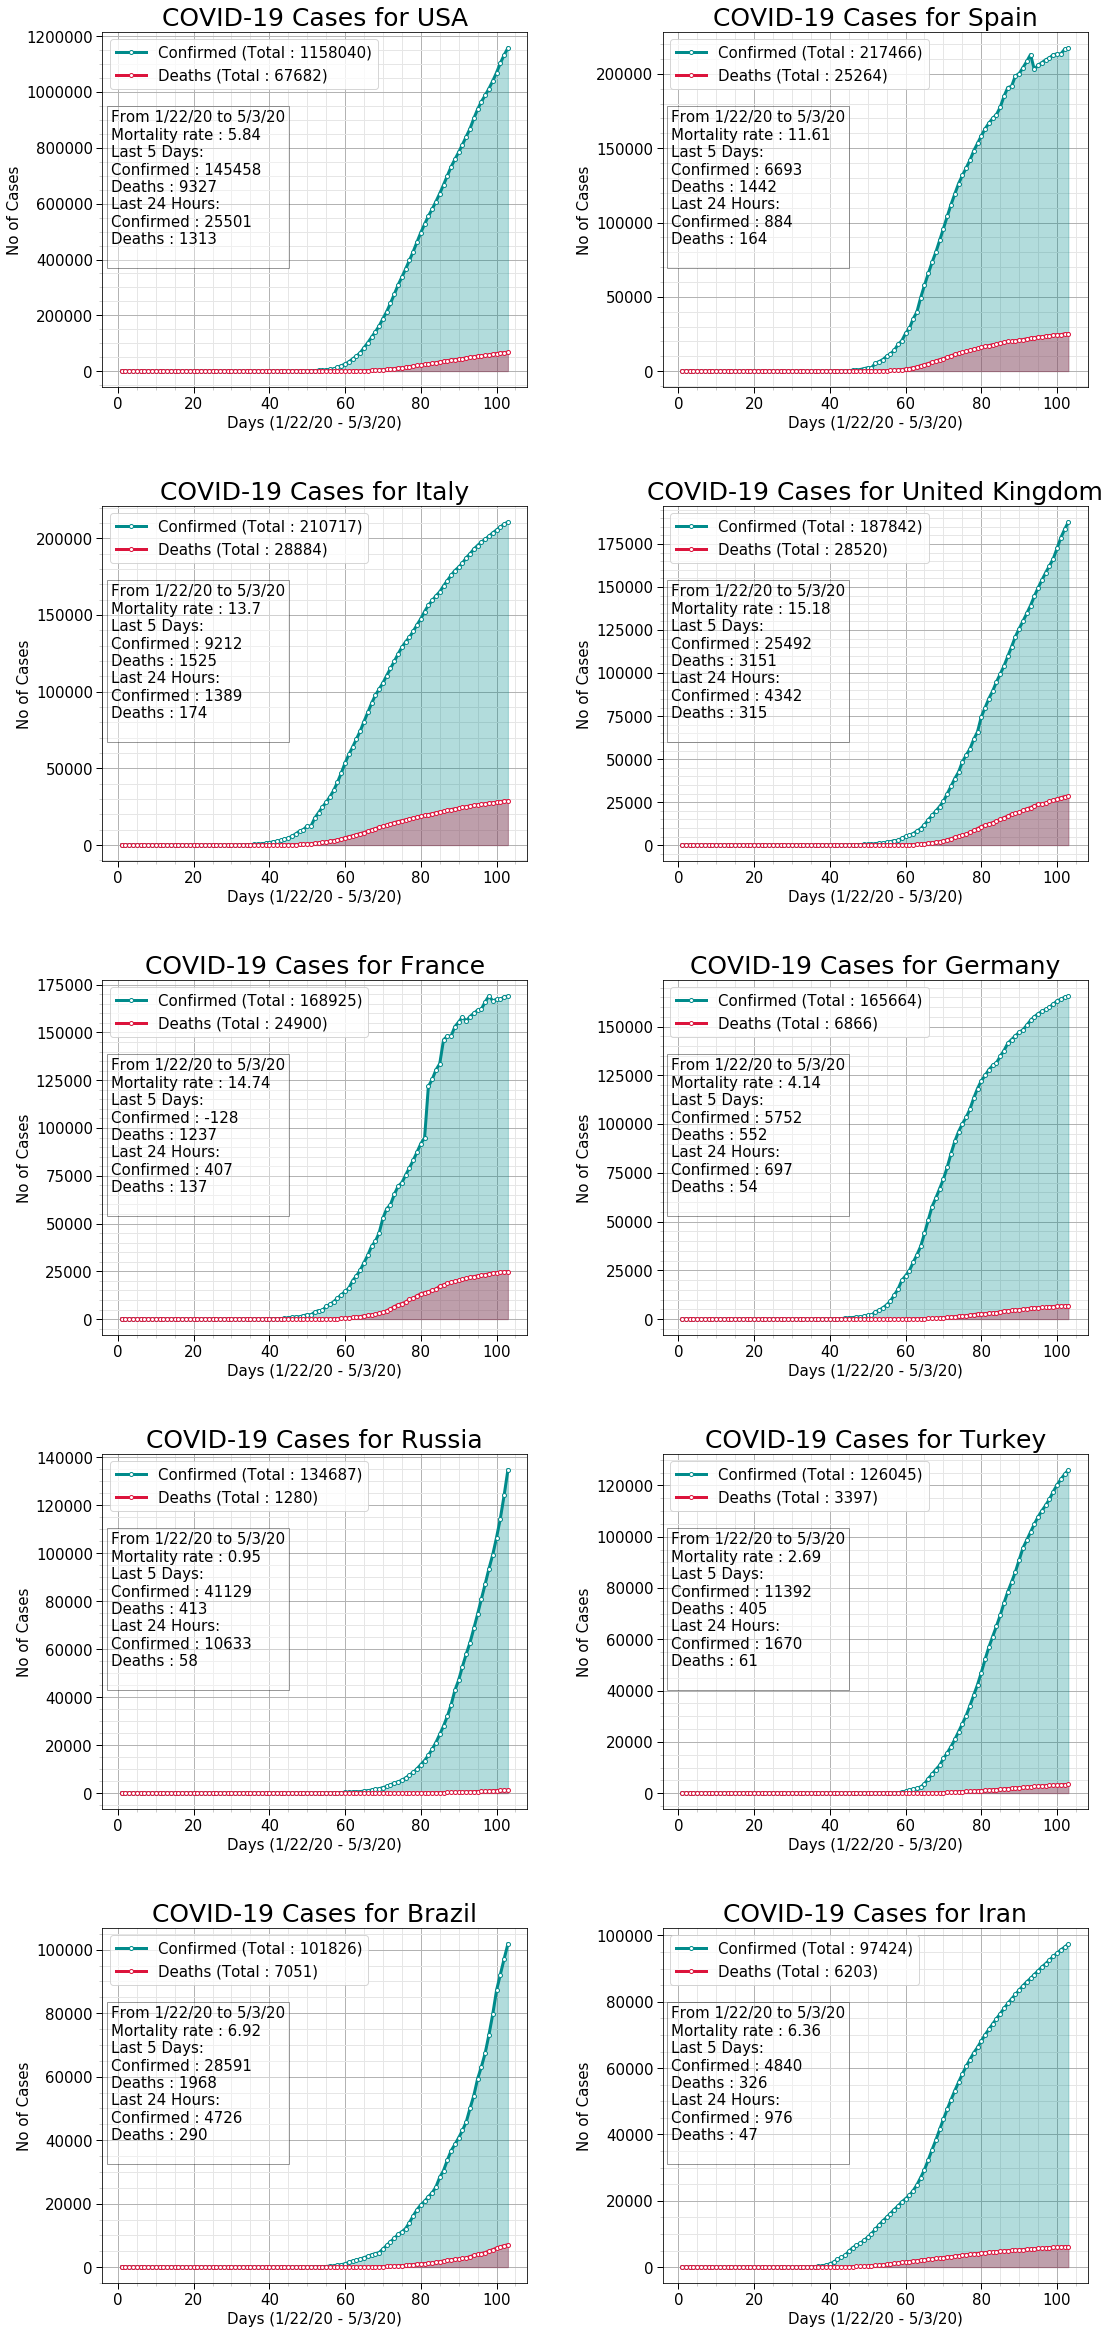

In [45]:
df_countries = df_confirmed.groupby(["country"]).sum()
df_countries = df_countries.sort_values(df_countries.columns[-1],ascending = False)
df_countries = df_countries.head(10)
countries = df_countries[df_countries[df_countries.columns[-1]] >= 4000].index

cols =2
rows = int(np.ceil(countries.shape[0]/cols))
f = plt.figure(figsize=(18,7*rows))
for i,country in enumerate(countries):
    visualize_covid_cases(df_confirmed, df_deaths,country = country,figure = [f,rows,cols, i+1])

plt.show()

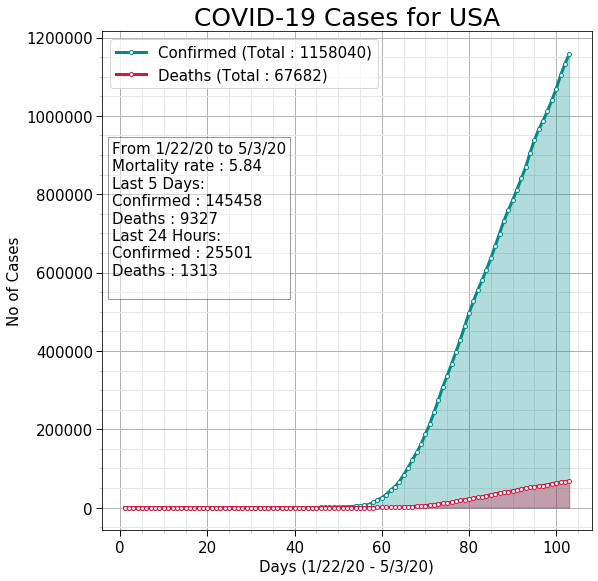

In [30]:
cols = 1
rows = 1
f = plt.figure(figsize=(10,10*rows))


visualize_covid_cases(df_confirmed, df_deaths,country = "USA",figure = [f,rows,cols, 1])
plt.show()

In [34]:
# model = models.load_model("model_confirmed_v3.h5")
# model.summary()

OSError: Unable to open file (unable to open file: name = './model_confirmed_v3.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [40]:
# thousand = 1000
# prediction_days = 10

# start_date = "4/5/20"
# sd= dd(start_date,"1/22/20")
# nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
# total =d+nextdays
# data_confirmed = np.power(10,model.predict(np.arange(1,len(data_y)+prediction_days+1)))
# data_deaths = np.power(10,model2.predict(np.arange(1,len(data_y)+prediction_days+1)))
# pd.DataFrame([total[sd:],
#               list(np.int64(np.round(data_confirmed[sd:].reshape(-1)/lakh,2)*lakh)),
#               list(df_confirmed.iloc[:,5:].sum(axis =0)[sd:]),
#               list(np.int64(np.round(data_deaths[sd:].reshape(-1)/thousand,2)*thousand)),
#              list(df_deaths.iloc[:,5:].sum(axis =0)[sd:])],
#              ["Date","Confirmed(Predicted)","Confirmed(Actual)","Deaths(Predicted)","Deaths(Actual)"]
#             ).transpose().set_index("Date")

NameError: name 'model' is not defined

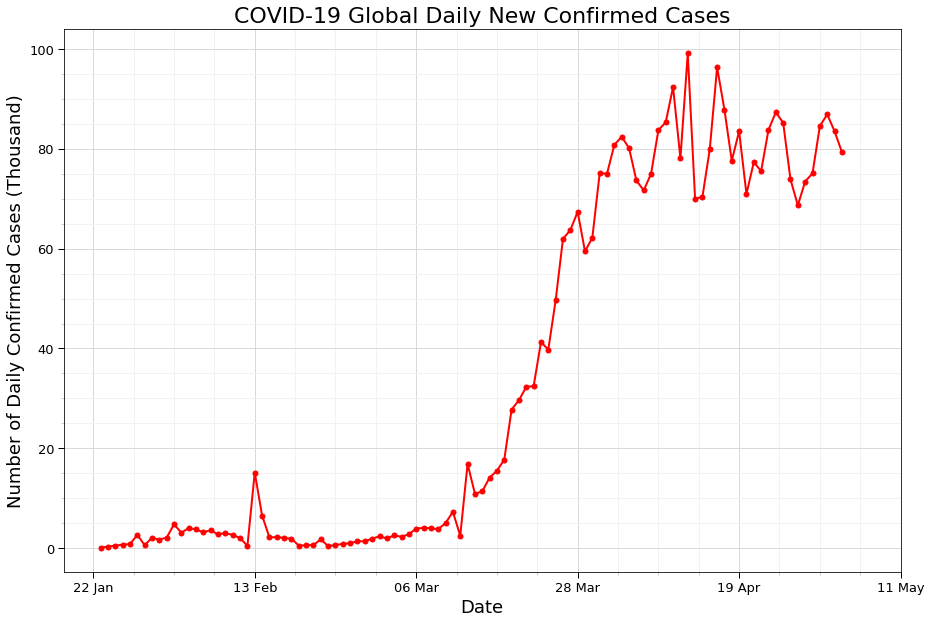

In [41]:
# Data
temp_data = np.nan_to_num(df_confirmed.sum()[5:].diff())


# Plot
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)


date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=2, linestyle='-', marker='o',markersize=5)
plt.plot(date,temp_data/thousand,"-.",color="red",**marker_style)


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=12)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.85", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.95", which = 'minor')

# Plot Title
plt.title("COVID-19 Global Daily New Confirmed Cases",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Confirmed Cases (Thousand)",fontsize =18)

# plt.yscale("log")
plt.tick_params(labelsize = 13) 
plt.savefig(out+"daily confirmed cases global.png")
plt.show()

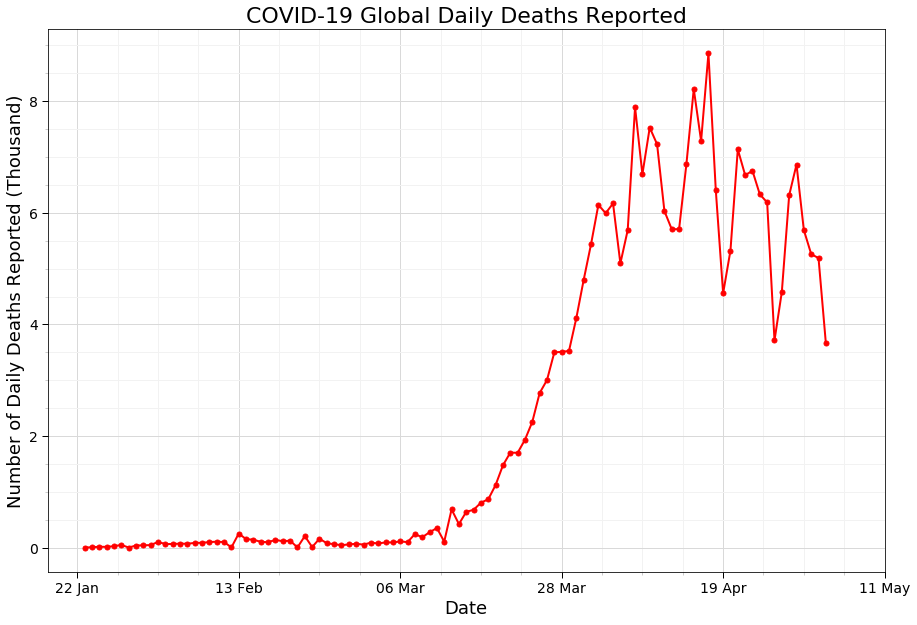

In [42]:
# Data
temp_data = np.nan_to_num(df_deaths.sum()[5:].diff())


# Plot
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)


date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=2, linestyle='-', marker='o',markersize=5)
plt.plot(date,temp_data/thousand,"-.",color="red",**marker_style)


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.85", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.95", which = 'minor')

# Plot Title
plt.title("COVID-19 Global Daily Deaths Reported",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Deaths Reported (Thousand)",fontsize =18)

# plt.yscale("log")
plt.savefig(out+"daily deaths cases Global.png")
plt.show()

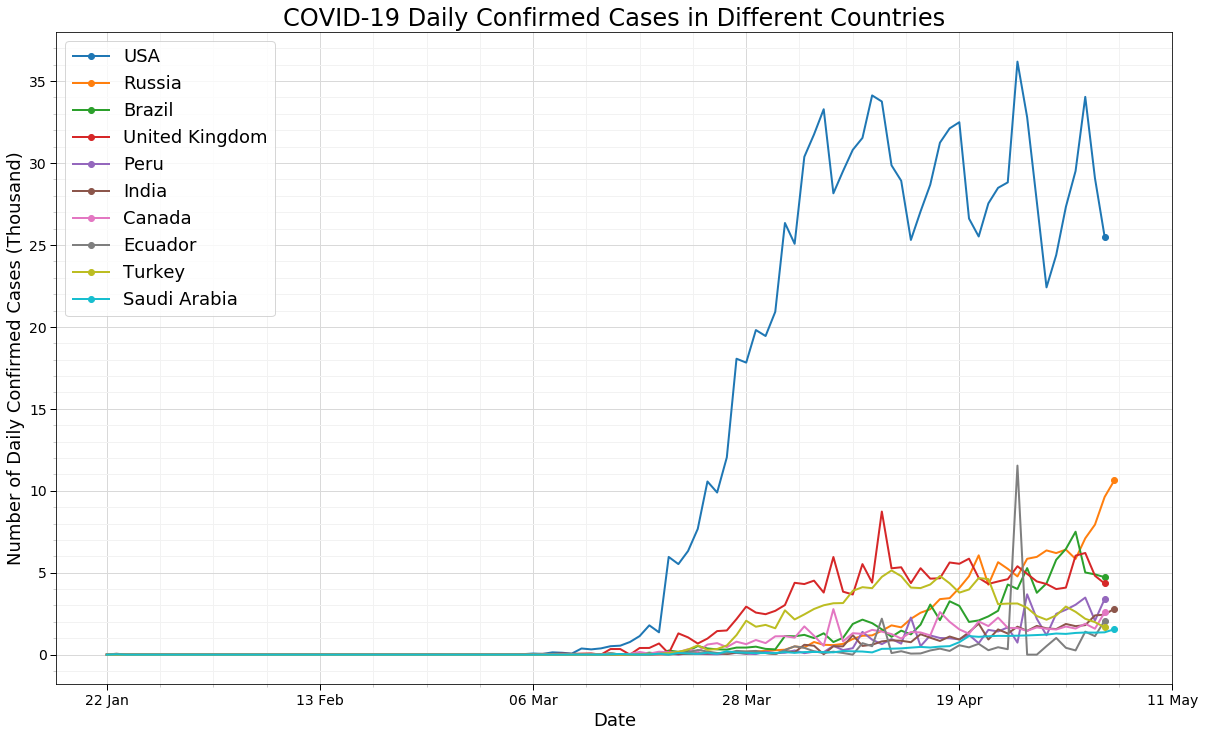

In [43]:
thoudand = 1000
temp = df_confirmed.groupby('country').sum().diff(axis=1).sort_values(df_deaths.columns[-1],ascending =False).head(10).replace(np.nan,0)
threshold = 0
f = plt.figure(figsize=(20,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    t = temp.loc[temp.index== country].values[0]
    t = t[t>=threshold]
    
    date = np.arange(0,len(t[:]))
    plt.plot(date,t/thoudand,'-o',label = country,linewidth =2, markevery=[-1])


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.85", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.95", which = 'minor')

# Plot Title
plt.title("COVID-19 Daily Confirmed Cases in Different Countries",{'fontsize':24})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Confirmed Cases (Thousand)",fontsize =18)

# plt.yscale("log")
plt.legend(fontsize=18) 
plt.savefig(out+"daily confirmed cases countrywise.png")
plt.show()

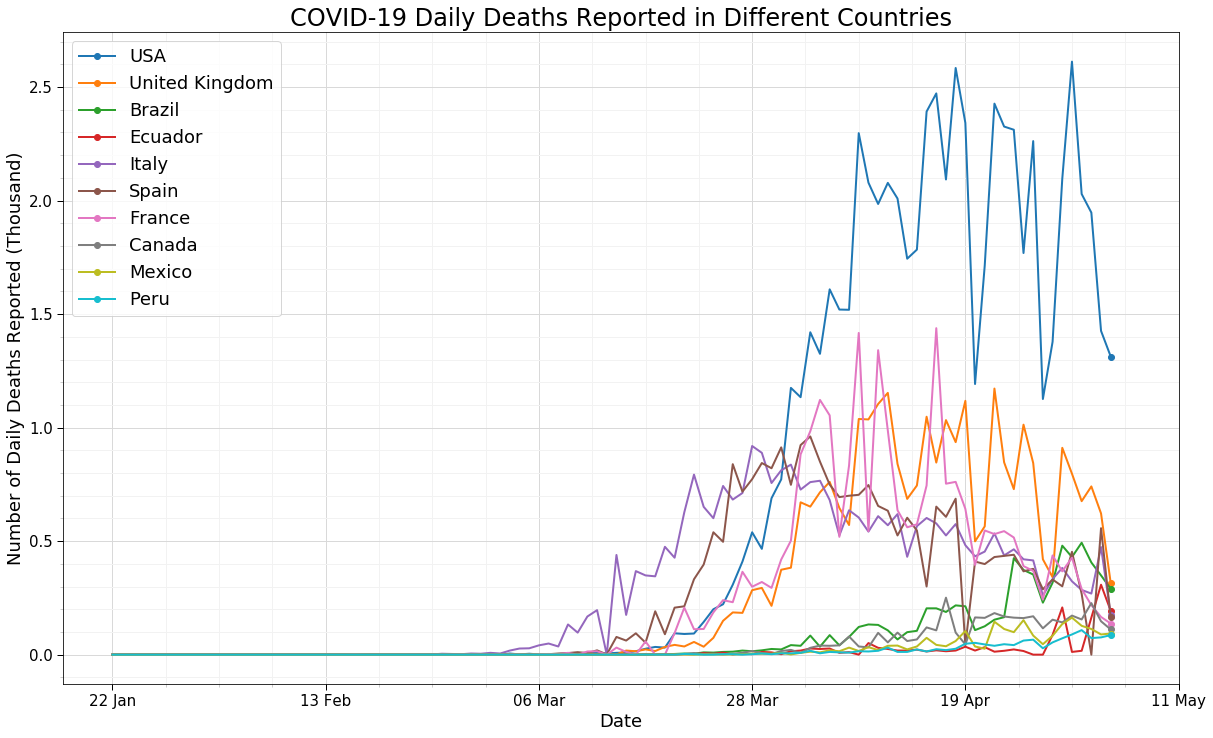

In [46]:
thoudand = 1000
temp = df_deaths.groupby('country').sum().diff(axis=1).sort_values(df_deaths.columns[-1],ascending =False).head(10).replace(np.nan,0)
threshold = 0
f = plt.figure(figsize=(20,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    t = temp.loc[temp.index== country].values[0]
    t = t[t>=threshold]
    
    date = np.arange(0,len(t[:]))
    plt.plot(date,t/thoudand,'-o',label = country,linewidth =2, markevery=[-1])


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=15)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.85", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.95", which = 'minor')

# Plot Title
plt.title("COVID-19 Daily Deaths Reported in Different Countries",{'fontsize':24})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Deaths Reported (Thousand)",fontsize =18)

# plt.yscale("log")
plt.legend(fontsize=18) 
plt.savefig(out+"daily deaths reported countrywise.png")
plt.show()

In [18]:
df_confirmed.head()

state      country continent      Lat     Long  1/22/20  1/23/20  1/24/20  \
0        Afghanistan      Asia  33.0000  65.0000        0        0        0   
1            Albania    Europe  41.1533  20.1683        0        0        0   
2            Algeria    Africa  28.0339   1.6596        0        0        0   
3            Andorra    Europe  42.5063   1.5218        0        0        0   
4             Angola    Africa -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  ...  4/24/20  4/25/20  4/26/20  4/27/20  4/28/20  \
0        0        0  ...     1351     1463     1531     1703     1828   
1        0        0  ...      678      712      726      736      750   
2        0        0  ...     3127     3256     3382     3517     3649   
3        0        0  ...      731      738      738      743      743   
4        0        0  ...       25       25       26       27       27   

   4/29/20  4/30/20  5/1/20  5/2/20  5/3/20  
0     1939     2171    2335    2469    2704  
1      766      773     782     789     795  
2     3848     4006    4154    4295    4474  
3      743      745     745     747     748  
4       27       27      30      35      35  

[5 rows x 108 columns]

In [90]:
all_column_name = list(df_confirmed.columns)
last_column_name = all_column_name[-1]
sorted_df_confirmed = df_confirmed.sort_values(last_column_name, ascending= False)
df_usa = sorted_df_confirmed.iloc[0,5:]
df_usa = df_usa.reset_index()
df_usa = df_usa.rename(columns={"index": "ds", 225: "y"})
df_usa

ds        y
0    1/22/20        1
1    1/23/20        1
2    1/24/20        2
3    1/25/20        2
4    1/26/20        5
..       ...      ...
98   4/29/20  1039909
99   4/30/20  1069424
100   5/1/20  1103461
101   5/2/20  1132539
102   5/3/20  1158040

[103 rows x 2 columns]

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from fbprophet import Prophet
import pycountry
import plotly.express as px
from collections import namedtuple

In [50]:
m = Prophet(interval_width=0.95)
m.fit(df_usa)
future = m.make_future_dataframe(periods=7)
future_confirmed = future.copy() # for non-baseline predictions later on
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
105 2020-05-06
106 2020-05-07
107 2020-05-08
108 2020-05-09
109 2020-05-10

In [51]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
105 2020-05-06  1.245310e+06  1.237675e+06  1.251992e+06
106 2020-05-07  1.275114e+06  1.264447e+06  1.284062e+06
107 2020-05-08  1.305552e+06  1.291511e+06  1.319339e+06
108 2020-05-09  1.334773e+06  1.316774e+06  1.351277e+06
109 2020-05-10  1.362612e+06  1.339863e+06  1.385076e+06

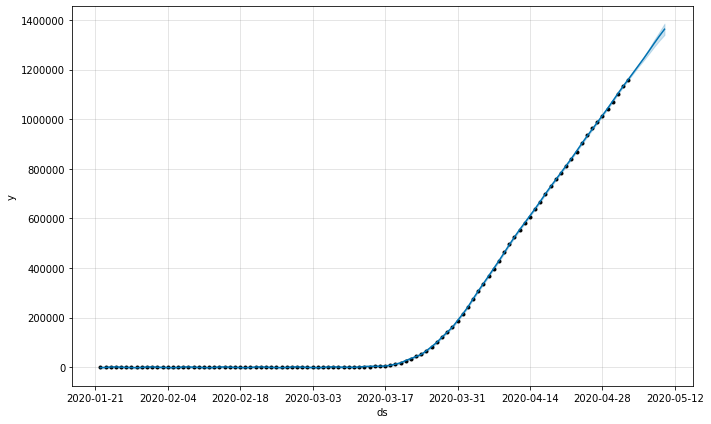

In [52]:
confirmed_forecast_plot = m.plot(forecast)


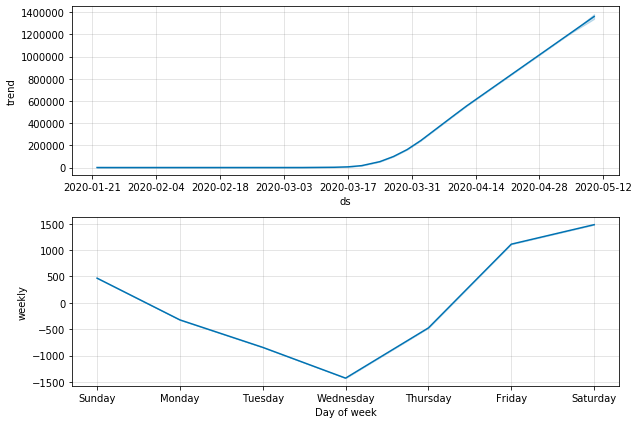

In [53]:
forecast_components = m.plot_components(forecast)

In [98]:
df_usa_daily_increase = df_usa
df_usa_daily_increase = df_usa_daily_increase.rename(columns={"y":"total_confirmed"})
# df_usa_daily_increase.columns
df_usa_daily_increase['new_confirmed'] = df_usa_daily_increase['total_confirmed']

# df_usa['new_confirmed'] = new_confirmed_temp
for i in range(len(df_usa_daily_increase['new_confirmed'])):
    if i == 0:
        df_usa_daily_increase.loc[i,'new_confirmed'] = 0
    else:
         df_usa_daily_increase.loc[i,'new_confirmed'] = df_usa_daily_increase.iloc[i]["new_confirmed"] - df_usa_daily_increase.iloc[i-1]["total_confirmed"]
df_usa_daily_increase

ds total_confirmed new_confirmed
0    1/22/20               1             0
1    1/23/20               1             0
2    1/24/20               2             1
3    1/25/20               2             0
4    1/26/20               5             3
..       ...             ...           ...
98   4/29/20         1039909         27327
99   4/30/20         1069424         29515
100   5/1/20         1103461         34037
101   5/2/20         1132539         29078
102   5/3/20         1158040         25501

[103 rows x 3 columns]

In [105]:
df_usa_daily_increase_predict = df_usa_daily_increase
df_usa_daily_increase_predict = df_usa_daily_increase_predict.drop(columns=['total_confirmed'])
df_usa_daily_increase = df_usa_daily_increase.rename(columns={"new_confirmed":"y"})
df_usa_daily_increase_predict

ds      y
0    1/22/20      0
1    1/23/20      0
2    1/24/20      1
3    1/25/20      0
4    1/26/20      3
..       ...    ...
98   4/29/20  27327
99   4/30/20  29515
100   5/1/20  34037
101   5/2/20  29078
102   5/3/20  25501

[103 rows x 2 columns]

In [106]:
m = Prophet(interval_width=0.95)
m.fit(df_usa_daily_increase_predict)
future = m.make_future_dataframe(periods=7)
future_confirmed = future.copy() # for non-baseline predictions later on
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
105 2020-05-06
106 2020-05-07
107 2020-05-08
108 2020-05-09
109 2020-05-10

In [107]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
105 2020-05-06  34831.109948  23485.500809  46867.929536
106 2020-05-07  36496.687647  26091.060063  47672.258986
107 2020-05-08  37460.513772  26833.083985  48837.854198
108 2020-05-09  37050.891908  25167.636596  48350.735706
109 2020-05-10  35832.303907  25044.030058  47278.768335

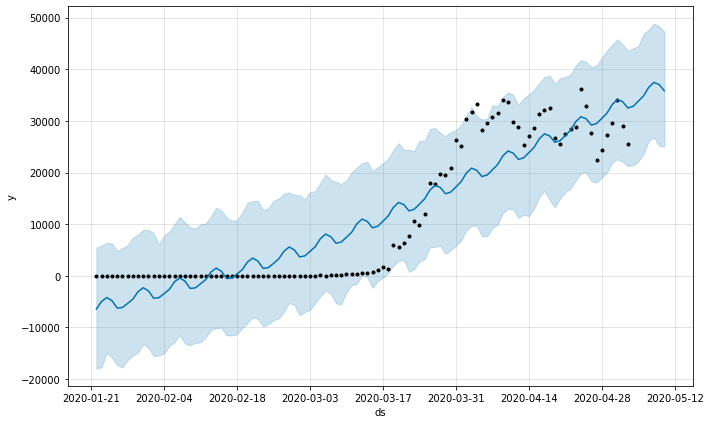

In [108]:
new_forecast_plot = m.plot(forecast)

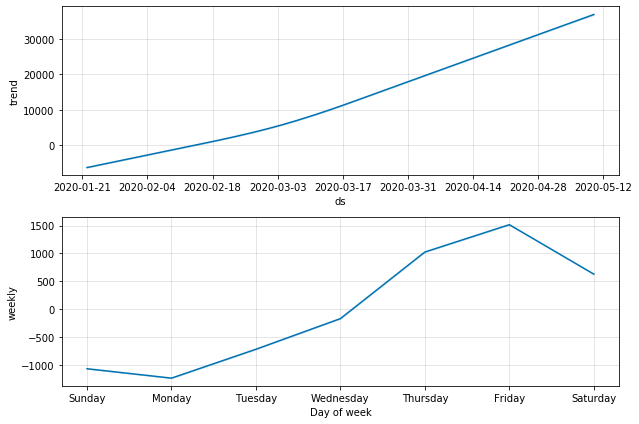

In [109]:
forecast_components = m.plot_components(forecast)

In [220]:
df_usa_daily_increase_predict

ds      y
0    1/22/20      0
1    1/23/20      0
2    1/24/20      1
3    1/25/20      0
4    1/26/20      3
..       ...    ...
98   4/29/20  27327
99   4/30/20  29515
100   5/1/20  34037
101   5/2/20  29078
102   5/3/20  25501

[103 rows x 2 columns]

In [113]:
usa_increase_started_March_28 = df_usa_daily_increase_predict.iloc[66:]